In [2]:
# importing libraries
import time
import pickle

from math import sqrt
from math import floor
from collections import defaultdict

# standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# library used for functional enrichment analysis
from func_e.FUNC_E import FUNC_E  # a method that can do funtional enrichment analysis!
import func_e.vocabs.all as vocabs

# following code is necessary as some functions used in the funcE class produce future warnings but i can't fix it as it is not my code
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# importing the custom classes i built
from matrix_class import ProteinMatrix # ppi matrix 
from cluster_class import AllClusters # dictionary to hold all clusters (in form number of cluster : list of proteins in that cluster)
from degreelist_class import DegreeList # creates a list of all proteins in order of their degree
from matrix_class import SubMatrix

# helper functions for setting up program
from recipe_utils import initialize_matrix_clusters_degreelist
from recipe_utils import find_clusters_and_proteins_together
from recipe_utils import find_clusters_and_proteins_together_og
from recipe_utils import get_initialized_fe

# helper functions for functional enrichment
from recipe_utils import print_querylist_of_clusters_to_file
from recipe_utils import print_protein_background_to_file
from recipe_utils import create_term_mapping_list

In [2]:
matrix, clusters, degreelist = initialize_matrix_clusters_degreelist("demo_data/dream3.txt", "demo_data/dream3_clusters.json")

In [74]:
def compute_qualifying_proteins(
    matrix,
    degreelist,
    clusters,
    metric = 'degree',
    sort_ascending = False,
    connectivity_threshold = 1,
    degree_cutoff = 5000
):
    proteins = matrix.get_list_of_proteins()
    degree_dict = dict(degreelist.sorted_protein_degree_dict)
    matrix_df = matrix.get_matrix()
    all_proteins_to_add = {}

    for cluster_num in clusters.get_all_cluster_labels():
        # initialise list of proteins to add
        added_proteins = []
        protein_to_add = "initialise"
        # get all the proteins associated to a cluster
        cluster_proteins = clusters.get_cluster_proteins(cluster_num)
        # get the list of potential proteins to add to cluster 
        potential_proteins = list(filter(lambda prot: prot not in cluster_proteins and degree_dict[prot] < degree_cutoff, proteins))
        # TODO: is there a better way of doing this??
        submatrix = SubMatrix(cluster_proteins, matrix)
        components_and_labels = submatrix.get_num_components_and_labels()
        num_components = components_and_labels[0]
        # current ratio of clusters to proteins
        num_proteins = len(cluster_proteins)
        percent_connectivity = (num_proteins - num_components)/num_proteins
        # loop through all the proteins and add proteins based on score
        while protein_to_add and percent_connectivity < connectivity_threshold:
            qualifying_proteins = {}
            # get sqrt of number of components in the subgraph
            connection_sitch = floor(sqrt(len(np.unique(components_and_labels[1]))))
            min_connection = connection_sitch if connection_sitch > 1 else 2

            for protein in potential_proteins:
                protein_degree = degree_dict[protein]
                if protein_degree >= min_connection:
                    # create component dictionary
                    protein_component_dictionary = dict(zip(submatrix.get_matrix().index, components_and_labels[1]))
                    # swap the values so the component number is the key
                    component_dictionary = defaultdict(list) 
                    for key, val in protein_component_dictionary.items():
                        component_dictionary[val].append(key)
                    # get number of connected components
                    num_components_protein_connects = 0
                    for component_number in range(num_components):
                        if next((prot for prot in component_dictionary[component_number] if matrix_df[prot][protein]), None):
                            num_components_protein_connects = num_components_protein_connects + 1
                    # if connection, greater than cutoff, consider for re-addition
                    if num_components_protein_connects >= min_connection:
                        qualifying_proteins[protein] = {
                            'components_connected': num_components_protein_connects,
                            'degree': protein_degree,
                            'score': num_components_protein_connects * (1 / protein_degree)
                        }
            protein_to_add = sorted(qualifying_proteins.items(), key = lambda x: x[1][metric], reverse=sort_ascending)[0][0] if qualifying_proteins else None
            if protein_to_add:
                potential_proteins.remove(protein_to_add)
                added_proteins.append(protein_to_add)
                percent_connectivity = (num_proteins - num_components)/num_proteins
                # get number of components in original cluster
                submatrix = SubMatrix(cluster_proteins + added_proteins, matrix)
                components_and_labels = submatrix.get_num_components_and_labels()
                num_components = components_and_labels[0]

        if len(added_proteins):
            all_proteins_to_add[cluster_num] = added_proteins
    return all_proteins_to_add

In [75]:
qualifying_proteins_by_metric = {}
connectivity_thresholds = [0.1, 0.25, 0.5, 0.75, 1]
metrics = {'degree': False, 'components_connected': True, 'score': True}
for metric in metrics.items():
    qualifying_proteins_at_threshold = {}
    for connectivity_threshold in connectivity_thresholds:
        qualifying_proteins = compute_qualifying_proteins(
            matrix,
            degreelist,
            clusters,
            metric = metric[0],
            sort_ascending = metric[1],
            connectivity_threshold = connectivity_threshold
        )
        if qualifying_proteins:
            qualifying_proteins_at_threshold[connectivity_threshold] = qualifying_proteins
    if qualifying_proteins_at_threshold:
        qualifying_proteins_by_metric[metric[0]] = qualifying_proteins_at_threshold

In [68]:
# create a binary pickle file 
f = open("all_qualifying_proteins.pkl","wb")
# write the python object (dict) to pickle file
pickle.dump(qualifying_proteins_by_metric,f)

READING DATA

In [3]:
with open('all_qualifying_proteins.pkl', 'rb') as handle:
    all_qualifying_proteins = pickle.load(handle)

In [4]:
# 1) a background protein list to be used for functional enrichment analysis
background_proteins_filepath = "demo_data/background_proteinlist.txt"
# 2) file containing protein to go term
term_mapping_filepath = "demo_data/term_mapping.txt"
# 3) not a file, but need to establish a background of all GO terms! (to be used for functional enrichment analysis)
background_go_terms = vocabs.getTerms(['GO'])

In [7]:
updated_fe = {}
connectivity_thresholds = [0.1, 0.25, 0.5, 0.75, 1]
metrics = {'degree': False, 'components_connected': True, 'score': True}
for metric in metrics.items():
    print("starting metric:", metric[0])
    updated_metric_fe = {}
    for connectivity_threshold in connectivity_thresholds:
        print("   - threshold:", connectivity_threshold)
        updated_query_filepath = 'demo_data/updated_query_' + metric[0] + '_' + str(connectivity_threshold) + '.txt'
        qualifying_proteins = all_qualifying_proteins[metric[0]][connectivity_threshold]
        print_querylist_of_clusters_to_file(clusters, clusters.get_all_cluster_labels(), updated_query_filepath, qualifying_proteins)
        # calculate functional enrichment
        updated_fe_all_proteins = get_initialized_fe(background_proteins_filepath, term_mapping_filepath, termlist = background_go_terms)
        updated_fe_all_proteins.importFiles({'query': updated_query_filepath })
        updated_fe_all_proteins.run(cluster=False)
        updated_metric_fe[connectivity_threshold] = updated_fe_all_proteins
    updated_fe[metric[0]] = updated_metric_fe

starting metric: ('degree', False)
   - threshold: 0.25
get_all_cluster_labels fxn has not been tested
   - threshold: 0.5
get_all_cluster_labels fxn has not been tested
   - threshold: 0.75
get_all_cluster_labels fxn has not been tested
   - threshold: 1
get_all_cluster_labels fxn has not been tested
starting metric: ('components_connected', True)
   - threshold: 0.25
get_all_cluster_labels fxn has not been tested
   - threshold: 0.5
get_all_cluster_labels fxn has not been tested
   - threshold: 0.75
get_all_cluster_labels fxn has not been tested
   - threshold: 1
get_all_cluster_labels fxn has not been tested
starting metric: ('score', True)
   - threshold: 0.25
get_all_cluster_labels fxn has not been tested
   - threshold: 0.5
get_all_cluster_labels fxn has not been tested
   - threshold: 0.75
get_all_cluster_labels fxn has not been tested
   - threshold: 1
get_all_cluster_labels fxn has not been tested


In [29]:
# create a binary pickle file 
f = open("updated_fe_obj.pkl","wb")
# write the python object (dict) to pickle file
pickle.dump(updated_fe,f)

In [5]:
import os
updated_fe = {}
target = "updated_fe_obj_dos.pkl"
if os.path.getsize(target) > 0:      
    with open(target, "rb") as f:
        unpickler = pickle.Unpickler(f)
        # if file is not empty scores will be equal
        # to the value unpickled
        updated_fe = unpickler.load()

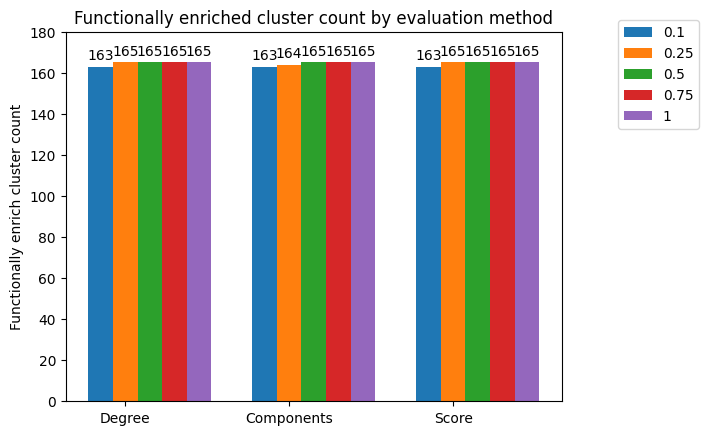

In [8]:
species = ("Degree", "Components", "Score")
penguin_means = {
    0.1: (
        updated_fe["degree"][0.1].enrichment['Module'].nunique(),
        updated_fe["components_connected"][0.1].enrichment['Module'].nunique(),
        updated_fe["score"][0.1].enrichment['Module'].nunique(),
    ),
    0.25: (
        updated_fe["degree"][0.25].enrichment['Module'].nunique(),
        updated_fe["components_connected"][0.25].enrichment['Module'].nunique(),
        updated_fe["score"][0.25].enrichment['Module'].nunique(),
    ),
    0.5: (
        updated_fe["degree"][0.5].enrichment['Module'].nunique(),
        updated_fe["components_connected"][0.5].enrichment['Module'].nunique(),
        updated_fe["score"][0.5].enrichment['Module'].nunique(),
    ),
    0.75: (
        updated_fe["degree"][0.75].enrichment['Module'].nunique(),
        updated_fe["components_connected"][0.75].enrichment['Module'].nunique(),
        updated_fe["score"][0.75].enrichment['Module'].nunique(),
    ),
    1: (
        updated_fe["degree"][1].enrichment['Module'].nunique(),
        updated_fe["components_connected"][1].enrichment['Module'].nunique(),
        updated_fe["score"][1].enrichment['Module'].nunique(),
    ),
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Functionally enrich cluster count')
ax.set_title('Functionally enriched cluster count by evaluation method')
ax.set_xticks((x + width), list(species))
# ax.legend(loc='upper left')
ax.set_ylim(0, 180)

ax.legend(bbox_to_anchor=(1.1, 1.05))

plt.show()

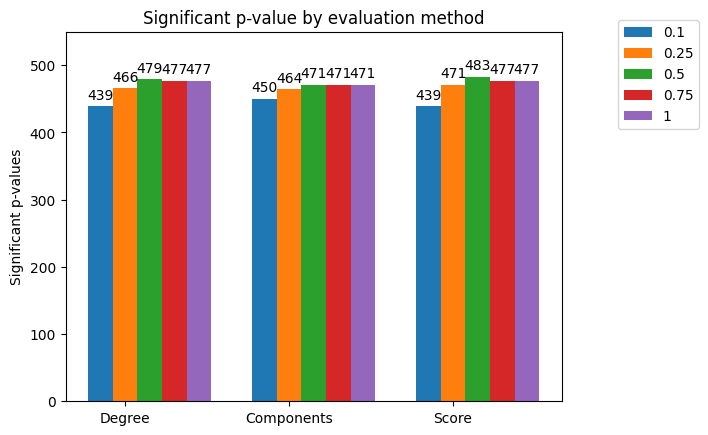

In [7]:
species = ("Degree", "Components", "Score")
penguin_means = {
    0.1: (
        updated_fe["degree"][0.1].enrichment['Fishers_pvalue'].count(),
        updated_fe["components_connected"][0.1].enrichment['Fishers_pvalue'].count(),
        updated_fe["score"][0.1].enrichment['Fishers_pvalue'].count(),
    ),
    0.25: (
        updated_fe["degree"][0.25].enrichment['Fishers_pvalue'].count(),
        updated_fe["components_connected"][0.25].enrichment['Fishers_pvalue'].count(),
        updated_fe["score"][0.25].enrichment['Fishers_pvalue'].count(),
    ),
    0.5: (
        updated_fe["degree"][0.5].enrichment['Fishers_pvalue'].count(),
        updated_fe["components_connected"][0.5].enrichment['Fishers_pvalue'].count(),
        updated_fe["score"][0.5].enrichment['Fishers_pvalue'].count(),
    ),
    0.75: (
        updated_fe["degree"][0.75].enrichment['Fishers_pvalue'].count(),
        updated_fe["components_connected"][0.75].enrichment['Fishers_pvalue'].count(),
        updated_fe["score"][0.75].enrichment['Fishers_pvalue'].count(),
    ),
    1: (
        updated_fe["degree"][1].enrichment['Fishers_pvalue'].count(),
        updated_fe["components_connected"][1].enrichment['Fishers_pvalue'].count(),
        updated_fe["score"][1].enrichment['Fishers_pvalue'].count(),
    ),
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Significant p-values')
ax.set_title('Significant p-value by evaluation method')
ax.set_xticks((x + width), list(species))
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylim(0, 550)

plt.show()